# Requirements

In [1]:
import math
import pickle
import pandas as pd
import numpy as np
import requests
import nltk

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD 
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

# Read data

In [2]:
# LAGT (v1.0.1) dataset directly from Zenodo
resp = requests.get("https://zenodo.org/record/4971946/files/LAGT_v1-0.json?download=1")
LAGT = pd.DataFrame(resp.json())

In [3]:
LAGT["lemmata"] = LAGT["lemmatized_sentences"].apply(lambda x: [item for sublist in x for item in sublist])

In [4]:
%%bash
curl https://raw.githubusercontent.com/kasev/paul/master/data/LAGT_metadata.csv -o ../data/LAGT_metadata.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  241k  100  241k    0     0   599k      0 --:--:-- --:--:-- --:--:--  601k


In [5]:
LAGT_metadata = pd.read_csv("../data/LAGT_metadata.csv")
provenience_dict = dict(zip(LAGT_metadata["filename"],  LAGT_metadata["provenience"]))
author_dict = dict(zip(LAGT_metadata["author_id"],  LAGT_metadata["author"]))
LAGT["provenience"] = LAGT["filename"].apply(lambda x: provenience_dict[x])

<AxesSubplot:xlabel='date_avr'>

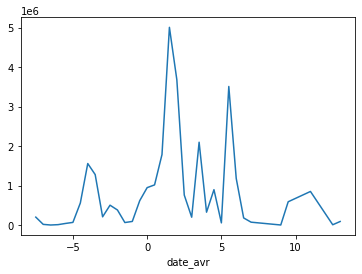

In [6]:
LAGT.groupby("date_avr").sum()["wordcount"].plot()

In [7]:

# function to extract all texts into one list of sentences
def get_flat_sentences(series):
    sentences_list = [sent for doc in series.tolist() for sent in doc]
    return sentences_list

In [8]:
sub_arc = LAGT[LAGT["date_avr"] < -5]
sub_cla = LAGT[LAGT["date_avr"].between(-5, -3.5)]
sub_hel = LAGT[LAGT["date_avr"].between(-3, -0.5)]
sub_rom = LAGT[(LAGT["date_avr"].between(0, 4.5)) & (LAGT["provenience"]=="pagan")]
sub_chr = LAGT[(LAGT["provenience"]=="christian") & (LAGT["date_avr"]<5)]
sub_jew = LAGT[(LAGT["provenience"]=="jewish") & (LAGT["date_avr"]<5)]
corpora_dfs = [sub_arc, sub_cla, sub_hel, sub_rom, sub_chr, sub_jew]
corpora_labels = ["Archaic", "Classical", "Hellenistic", "Roman", "Christian", "Jewish"]

In [9]:
corpora = []
for corp_df, label in zip(corpora_dfs, corpora_labels):
    corpus = {}
    corpus["label"] = label
    corpus["n_authors"] = len(list(corp_df["author_id"].unique()))
    corpus["n_works"] = len(corp_df)
    corpus["n_sentences"] = corp_df["n_sentences"].sum()
    corpus["wordcount"] = corp_df["wordcount"].sum()
    corpus["sentences"] = get_flat_sentences(corp_df["lemmatized_sentences"])
    corpus["lemmata"] = [item for sublist in corp_df["lemmata"].tolist() for item in sublist] 
    corpora.append(corpus)

In [10]:
pd.DataFrame(corpora)

,label,n_authors,n_works,n_sentences,wordcount,sentences,lemmata
0,Archaic,8,12,20502,265138,"[[μῆνις, ἀείδω, θεά, Πηλείδης, Ἀχιλλεύς, οὐλόμ...","[μῆνις, ἀείδω, θεά, Πηλείδης, Ἀχιλλεύς, οὐλόμε..."
1,Classical,36,367,256084,3460971,"[[θουκυδίδης, Ἀθηναῖος, συγγράφω, πόλεμος, Πελ...","[θουκυδίδης, Ἀθηναῖος, συγγράφω, πόλεμος, Πελο..."
2,Hellenistic,34,96,154615,1860841,"[[ἄρχω, Φοῖβος, παλαιγενής, κλέος, φώς, μιμνήσ...","[ἄρχω, Φοῖβος, παλαιγενής, κλέος, φώς, μιμνήσκ..."
3,Roman,97,609,1014984,11981922,"[[φιλοσοφία, ἔργον, ἔνιοι, φημί, βάρβαρος, ἄρχ...","[φιλοσοφία, ἔργον, ἔνιοι, φημί, βάρβαρος, ἄρχω..."
4,Christian,49,148,343318,3566823,"[[βίβλος, γένεσις, Ἰησοῦς, Χριστός, υἱός, Δαυί...","[βίβλος, γένεσις, Ἰησοῦς, Χριστός, υἱός, Δαυίδ..."
5,Jewish,5,40,108194,1154228,"[[ἄλλος, νομοθέτης, ἀκαλλώπιστος, γυμνός, νομι...","[ἄλλος, νομοθέτης, ἀκαλλώπιστος, γυμνός, νομισ..."


# Embeddings - preprocessing

In [11]:
sentences = corpora[0]["sentences"]
min_freq = 5

def get_vocab(docs, min_freq=5):
    words_flat = [item for sublist in docs for item in sublist] 
    word_freq_tups = nltk.FreqDist(words_flat).most_common()
    vocabulary = [tup[0] for tup in word_freq_tups if tup[1] >= min_freq]
    #vocab_freqs = [len([doc for doc in docs if word in doc]) for word in vocabulary]
    return words_flat, vocabulary # , vocab_freqs

In [20]:
words_flat, vocabulary = get_vocab(sentences)

In [21]:
len(set(corpora[0]["lemmata"]))

15329

In [22]:
len(list(set(corpora[0]["lemmata"]) & set(corpora[1]["lemmata"])))

8760

In [23]:
vocabs_list = []
for corp in corpora:
    if corp["label"] not in ["christian", "jewish"]:
        vocabs_list.append(get_vocab(corp["sentences"])[1])

In [24]:
vocab_intersect = list(set.intersection(*map(set,vocabs_list)))
len(vocab_intersect)

1733

In [25]:
def get_cooc(docs, vocabulary=None, min_freq=5):
    if vocabulary==None:
        lemmata, vocabulary = get_vocab(docs, min_freq)
    vec_bow = CountVectorizer(vocabulary=vocabulary, lowercase=False) 
    bow = vec_bow.fit_transform([" ".join(list(set(sentence))) for sentence in docs])
    cooc  = bow.T * bow
    cooc = cooc / len(docs)
    return cooc, vocabulary

In [26]:
small_voc = ['εἰμί', 'αὐτός', 'πᾶς', 'ἀνήρ', 'πολύς', 'φημί', 'ἔχω', 'θεός', 'Ζεύς', 'μέγας']

In [27]:
cooc, vocab = get_cooc(sentences, vocabulary=small_voc, min_freq=5)

In [28]:
cooc.todense()

matrix([[0.11545215, 0.00931616, 0.00946249, 0.01068188, 0.00999902,
         0.00473125, 0.0048288 , 0.01014535, 0.0064384 , 0.00673105],
        [0.00931616, 0.07443176, 0.00551166, 0.00404839, 0.00492635,
         0.00365818, 0.0048288 , 0.00424349, 0.00370696, 0.00365818],
        [0.00946249, 0.00551166, 0.06540825, 0.00434104, 0.00312165,
         0.00390206, 0.00424349, 0.00687738, 0.00399961, 0.0032192 ],
        [0.01068188, 0.00404839, 0.00434104, 0.05979904, 0.00692615,
         0.00258511, 0.00414594, 0.00595064, 0.00365818, 0.00399961],
        [0.00999902, 0.00492635, 0.00312165, 0.00692615, 0.05448249,
         0.00165837, 0.00307287, 0.00258511, 0.00307287, 0.00326797],
        [0.00473125, 0.00365818, 0.00390206, 0.00258511, 0.00165837,
         0.0550678 , 0.00175593, 0.00195103, 0.00185348, 0.00175593],
        [0.0048288 , 0.0048288 , 0.00424349, 0.00414594, 0.00307287,
         0.00175593, 0.05058043, 0.00463369, 0.00224368, 0.00273144],
        [0.01014535, 0.0042

In [519]:
cooc, vocabulary = get_cooc(corpora[0]["sentences"], vocabulary=vocab_intersect)
cooc.todense()

matrix([[0.00692615, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.00126817, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.00039021, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.00058531, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.00243879,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.00312165]])

In [520]:
cooc.todense().shape

(2134, 2134)

In [521]:
len(vocabulary)

2134

In [29]:
# deal with division by zero
ab_3 = np.array([2, 0, 5, 0], dtype=float)
axb = np.array([2, 0, 5, 1], dtype=float)

np.divide(ab_3, axb, out=np.zeros_like(ab_3), where=axb!=0)

array([1., 0., 1., 0.])

In [30]:
def normalize_ppmi3_matrix(pmi_matrix_df):
    minval, maxval = pmi_matrix_df.min().min(), pmi_matrix_df.max().max()
    minval_2 = minval * 2
    pmi_matrix_df.fillna(minval_2, inplace=True)
    pmi_matrix_norm_df = (pmi_matrix_df - minval_2) / (maxval - minval_2)
    return pmi_matrix_norm_df

In [31]:
def get_ppmi3_df(cooc, vocabulary, normalize=True, exp=3):
    pmi_rows_list = []
    for i in range(cooc.shape[1]):
        ab = np.array([row_el for row_el in list(cooc[i].toarray()[0])], dtype=float)
        ab_exp = np.power(ab, exp)
        axb = np.array([cooc[row_el[0], row_el[0]] * cooc[i, i] for row_el in enumerate(list(cooc[i].toarray()[0]))], dtype=float)
        pmi_row = np.divide(ab_exp, axb, out=np.zeros_like(ab_exp), where=axb!=0)
        pmi_row = [np.log(n) if n>0 else None for n in pmi_row]
        pmi_rows_list.append(pmi_row)
    pmi_matrix_df = pd.DataFrame(pmi_rows_list, columns=vocabulary, index=vocabulary)
    if normalize == True:
        pmi_matrix_df = normalize_ppmi3_matrix(pmi_matrix_df)
        np.fill_diagonal(pmi_matrix_df.to_numpy(), 1)
    return pmi_matrix_df #pmi_matrix_norm_df

In [32]:
%%time
data = get_ppmi3_df(cooc, small_voc, exp=2)
data.head(10)

CPU times: user 22 ms, sys: 390 µs, total: 22.4 ms
Wall time: 19.7 ms


,εἰμί,αὐτός,πᾶς,ἀνήρ,πολύς,φημί,ἔχω,θεός,Ζεύς,μέγας
εἰμί,1.000000,0.671523,0.682989,0.706727,0.703939,0.596195,0.605189,0.714140,0.652056,0.659313
αὐτός,0.671523,1.000000,0.637100,0.599398,0.634115,0.590800,0.636567,0.620907,0.604509,0.603517
πᾶς,0.682989,0.637100,1.000000,0.618614,0.578127,0.609265,0.627333,0.699175,0.624610,0.594479
ἀνήρ,0.706727,0.599398,0.618614,1.000000,0.698470,0.556810,0.630417,0.684892,0.618262,0.631921
πολύς,0.703939,0.634115,0.578127,0.698470,1.000000,0.500000,0.594252,0.572354,0.599991,0.609694
φημί,0.596195,0.590800,0.609265,0.556810,0.500000,1.000000,0.513484,0.531358,0.526952,0.520125
ἔχω,0.605189,0.636567,0.627333,0.630417,0.594252,0.513484,1.000000,0.661098,0.560342,0.589367
θεός,0.714140,0.620907,0.699175,0.684892,0.572354,0.531358,0.661098,1.000000,0.704923,0.639551
Ζεύς,0.652056,0.604509,0.624610,0.618262,0.599991,0.526952,0.560342,0.704923,1.000000,0.672163
μέγας,0.659313,0.603517,0.594479,0.631921,0.609694,0.520125,0.589367,0.639551,0.672163,1.000000


In [33]:
def svd_reduction(cooc_matrix, n_components=300, random_state=1, n_iter=100):
    svd = TruncatedSVD(n_components=n_components, random_state=random_state, n_iter=n_iter)
    svd_matrix = svd.fit_transform(cooc_matrix)
    return svd_matrix

In [34]:
def from_docs_to_embeddings(docs, vocabulary=None, min_freq=5):
    cooc, vocabulary = get_cooc(docs, vocabulary=vocabulary, min_freq=min_freq)
    pmi_matrix = get_ppmi3_df(cooc, vocabulary)
    word_vectors_array = svd_reduction(pmi_matrix, n_components=300, random_state=1, n_iter=100)
    word_vectors_df = pd.DataFrame(word_vectors_array, index=vocabulary)
    pmi_svd_cos = pd.DataFrame(cosine_similarity(word_vectors_array), columns=vocabulary, index=vocabulary)
    return [cooc, vocabulary, pmi_matrix, word_vectors_df, pmi_svd_cos]

In [562]:
%%time
data_arc = from_docs_to_embeddings(corpora[0]["sentences"], vocabulary=vocab_intersect)

CPU times: user 6min 10s, sys: 3min 20s, total: 9min 31s
Wall time: 2min 38s


In [564]:
data_arc[-1].head(10)

,ἴσος,ἄγαμαι,πηδάλιον,ἰός,ἐπίσταμαι,χρίω,ψυχή,μάγειρος,πιστεύω,πλῆθος,...,αἰτία,εὔκαιρος,σταθμόν,μικρός,τετράς,ἀποκρύπτω,σπόγγος,ἐπιλανθάνομαι,ἀνάγκη,ἀγείρω
ἴσος,1.000000,0.437380,0.233293,0.405049,0.419086,0.342806,0.533856,0.248857,0.185417,0.248479,...,0.313441,0.142484,0.281288,0.283408,0.150039,0.280582,0.160631,0.269607,0.422556,0.514216
ἄγαμαι,0.437380,1.000000,0.269362,0.364781,0.475348,0.295286,0.442968,0.242076,0.277596,0.333559,...,0.300841,0.153856,0.307053,0.247433,0.045151,0.332806,0.099603,0.230892,0.364311,0.431784
πηδάλιον,0.233293,0.269362,1.000000,0.247571,0.199008,0.189989,0.191425,0.163811,0.102286,0.146196,...,0.173133,0.060075,0.159814,0.159377,0.062967,0.171380,0.099153,0.129346,0.204302,0.254487
ἰός,0.405049,0.364781,0.247571,1.000000,0.320457,0.454405,0.364298,0.141678,0.134110,0.291070,...,0.169091,0.131967,0.461251,0.167599,0.158737,0.247464,0.148443,0.141628,0.288210,0.378224
ἐπίσταμαι,0.419086,0.475348,0.199008,0.320457,1.000000,0.230885,0.440608,0.196935,0.241799,0.273977,...,0.232209,0.168305,0.233377,0.285050,0.131886,0.272784,0.197518,0.145131,0.318963,0.416386
χρίω,0.342806,0.295286,0.189989,0.454405,0.230885,1.000000,0.309278,0.198141,0.105399,0.252703,...,0.181133,0.136287,0.397811,0.151169,0.188259,0.155586,0.164157,0.205116,0.219056,0.284210
ψυχή,0.533856,0.442968,0.191425,0.364298,0.440608,0.309278,1.000000,0.210131,0.258478,0.289317,...,0.306682,0.305622,0.313378,0.298504,0.191366,0.293311,0.185946,0.274149,0.381677,0.503057
μάγειρος,0.248857,0.242076,0.163811,0.141678,0.196935,0.198141,0.210131,1.000000,0.386127,0.218486,...,0.419825,0.194187,0.157304,0.395120,0.107027,0.163988,0.119396,0.170859,0.214792,0.218624
πιστεύω,0.185417,0.277596,0.102286,0.134110,0.241799,0.105399,0.258478,0.386127,1.000000,0.304259,...,0.398754,0.228936,0.196975,0.401746,0.093387,0.152211,0.104865,0.191227,0.259909,0.192493
πλῆθος,0.248479,0.333559,0.146196,0.291070,0.273977,0.252703,0.289317,0.218486,0.304259,1.000000,...,0.212670,0.340080,0.352277,0.256561,0.063725,0.303495,0.122820,0.186541,0.282018,0.296108


In [568]:
data_arc[-1].sort_values("θεός", ascending=False)["θεός"][1:20]

πᾶς         0.814797
εἰμί        0.814371
ἀνήρ        0.801801
Ζεύς        0.797828
ἄλλος       0.795510
αὐτός       0.785393
ἔχω         0.779031
μέγας       0.777457
ἀθάνατος    0.769020
πολύς       0.760543
ναῦς        0.760385
θυμός       0.757877
φίλος       0.757333
γαῖα        0.756469
Ἀχαιός      0.751522
ἔρχομαι     0.748399
δίδωμι      0.742026
εἶμι        0.737592
Ὀδυσσεύς    0.736984
Name: θεός, dtype: float64

In [578]:
pd.DataFrame(corpora)

,label,n_authors,n_works,n_sentences,wordcount,sentences,lemmata
0,Archaic,8,12,20502,265138,"[[μῆνις, ἀείδω, θεά, Πηλείδης, Ἀχιλλεύς, οὐλόμ...","[μῆνις, ἀείδω, θεά, Πηλείδης, Ἀχιλλεύς, οὐλόμε..."
1,Classical,36,367,256084,3460971,"[[θουκυδίδης, Ἀθηναῖος, συγγράφω, πόλεμος, Πελ...","[θουκυδίδης, Ἀθηναῖος, συγγράφω, πόλεμος, Πελο..."
2,Hellenistic,34,96,154615,1860841,"[[ἄρχω, Φοῖβος, παλαιγενής, κλέος, φώς, μιμνήσ...","[ἄρχω, Φοῖβος, παλαιγενής, κλέος, φώς, μιμνήσκ..."
3,Roman,97,609,1014984,11981922,"[[φιλοσοφία, ἔργον, ἔνιοι, φημί, βάρβαρος, ἄρχ...","[φιλοσοφία, ἔργον, ἔνιοι, φημί, βάρβαρος, ἄρχω..."
4,Christian,49,148,343318,3566823,"[[βίβλος, γένεσις, Ἰησοῦς, Χριστός, υἱός, Δαυί...","[βίβλος, γένεσις, Ἰησοῦς, Χριστός, υἱός, Δαυίδ..."
5,Jewish,5,40,108194,1154228,"[[ἄλλος, νομοθέτης, ἀκαλλώπιστος, γυμνός, νομι...","[ἄλλος, νομοθέτης, ἀκαλλώπιστος, γυμνός, νομισ..."


In [ ]:
%%time
#data_arc = from_docs_to_embeddings(corpora[0]["sentences"], min_freq=10)
#pickle.dump(data_arc, open("../data/large_files/embeddings_Archaic.pkl", "wb"), pickle.HIGHEST_PROTOCOL)
#data_cla = from_docs_to_embeddings(corpora[1]["sentences"], min_freq=10)
#pickle.dump(data_cla, open("../data/large_files/embeddings_Classical.pkl", "wb"), pickle.HIGHEST_PROTOCOL)
#data_hel = from_docs_to_embeddings(corpora[2]["sentences"], min_freq=10)
#pickle.dump(data_hel, open("../data/large_files/embeddings_Hellenistic.pkl", "wb"), pickle.HIGHEST_PROTOCOL)


#data_rom = from_docs_to_embeddings(corpora[3]["sentences"], min_freq=10)
#print("Roman - complete")
data_chr = from_docs_to_embeddings(corpora[4]["sentences"], min_freq=10)
pickle.dump(data_chr, open("../data/large_files/embeddings_Christian.pkl", "wb"), pickle.HIGHEST_PROTOCOL)
print("Christian - complete")
data_jew = from_docs_to_embeddings(corpora[5]["sentences"], min_freq=10)
pickle.dump(data_jew, open("../data/large_files/embeddings_Jewish.pkl", "wb"), pickle.HIGHEST_PROTOCOL)
print("Jewish - complete")

In [36]:
del data_chr
del data_jew

In [ ]:
%%time
# computationally heavy, use carefully...
data_rom = from_docs_to_embeddings(corpora[3]["sentences"], min_freq=10)
pickle.dump(data_rom, open("../data/large_files/embeddings_Roman.pkl", "wb"), pickle.HIGHEST_PROTOCOL)